## Tutorial: how to import the data and visualise them

In [1]:
import numpy as np
import networkx as nx
import random
from tqdm import tqdm
#from tree import FamilyTree
from data_handler import ParticleDataset

import matplotlib.pyplot as plt
from matplotlib.patches import Circle,ConnectionPatch

#helper functions for plots
from utils.visualisation import plot_geodesic, get_colors, hard_descendants
from utils.metrics import sqdist, distance_matrix, precision_and_recall

from jupyterthemes import jtplot
jtplot.style(theme='oceans16')

INFO: Using numpy backend


## The dataset

The dataset is structured as a Pytorch dataset. The two inputs are the path for the data directory and the signal name (this depends on the physics event we are interested in and it is chosen once the data is generated).

The dataset spits each event as dictionary which contains a graphicle object and a hyperbolic coordinates array for each of the algorithm tree (AntiKt, CA and Kt) and for the MC truth.

In [2]:
dataset = ParticleDataset('data/test3', 'signal')
event = dataset.__getitem__(0)

### For test3 I used: lr=0.5, epochs=150, steps=10
### For test2 I used: lr=0.3, epochs=120, steps=7

In [3]:
event.keys()

dict_keys(['MC_graph', 'MC_hyp', 'aKt_graph', 'aKt_hyp', 'CA_graph', 'CA_hyp', 'Kt_graph', 'Kt_hyp'])

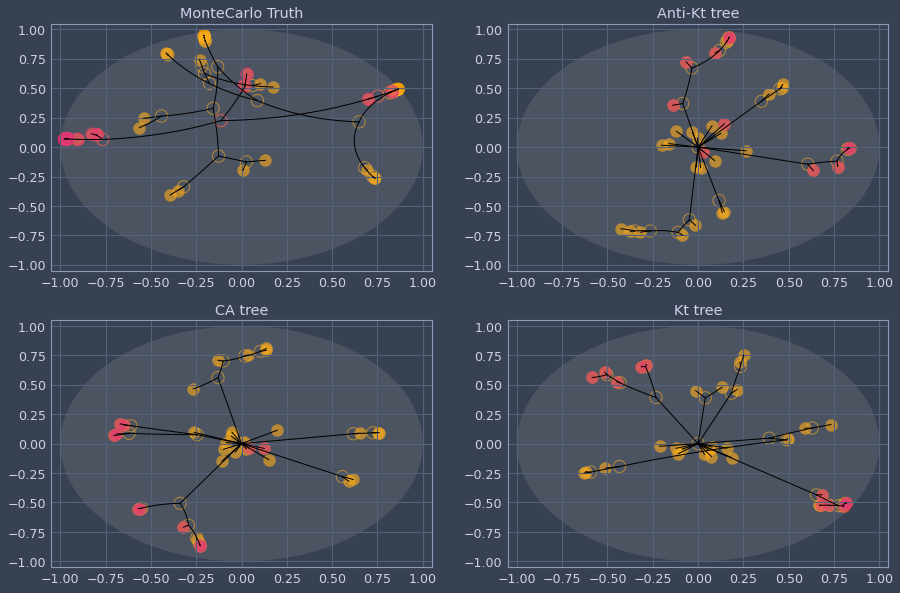

In [4]:
fig,ax = plt.subplots(2,2,figsize=(15,10))
ax = ax.flatten()

keys = [k for k in event.keys()]
titles = [ 'MonteCarlo Truth', 'Anti-Kt tree', 'CA tree', 'Kt tree',]
for k in range(0, 7, 2):
    i = k//2
    graph, hyp = event[keys[k]], event[keys[k+1]]
    
    for edge in graph.edges:
        start = np.where(graph.nodes == edge[0])[0][0]
        end = np.where(graph.nodes == edge[1])[0][0]
        x0,y0 = hyp[start]
        x1,y1 = hyp[end]
        #ax.plot([x0,x1],[y0,y1],alpha=0.1,color='black')
        plot_geodesic(hyp[start],hyp[end],ax[i])
    
    if i ==0:
        #'#DB2065'
        mask = graph.final.data
        ax[i].scatter(hyp[:,0][mask], hyp[:,1][mask], 
            c='orange', s=150, alpha=0.6)
        ax[i].scatter(hyp[:,0][~mask], hyp[:,1][~mask], 
            facecolor='none',edgecolor='orange',linewidth=1, s=150, alpha=0.6)
        
        hard_mask = hard_descendants(graph, 25)
        ax[i].scatter(hyp[:,0][hard_mask * mask], hyp[:,1][hard_mask * mask], 
            c='#DB2065', s=150, alpha=0.6)
        ax[i].scatter(hyp[:,0][hard_mask], hyp[:,1][hard_mask], 
            facecolor='none',edgecolor='#DB2065',linewidth=1, s=150, alpha=0.6)
        
        hard_mask = hard_mask[mask]
                      
    else:
        mask = graph.final.data
        
        colors = np.array(get_colors(graph))
        ax[i].scatter(hyp[:,0][mask], hyp[:,1][mask], 
            c='orange', s=150, alpha=0.6)
        ax[i].scatter(hyp[:,0][~mask], hyp[:,1][~mask], 
            facecolor='none',edgecolor='orange',linewidth=1, s=150, alpha=0.6)
        
        ax[i].scatter(hyp[:,0][mask][hard_mask], hyp[:,1][mask][hard_mask], 
            c='#DB2065', s=150, alpha=0.6)
        #ax[i].scatter(hyp[:,0][mask][~hard_mask], hyp[:,1][mask][~hard_mask], 
        #    facecolor='none',edgecolor='#DB2065',linewidth=1, s=150, alpha=0.6)
    
    disk = Circle((0,0),1,color='white',alpha=0.1)#fill=False)
    ax[i].add_patch(disk)
    ax[i].set_xlim(-1.05,1.05)
    ax[i].set_ylim(-1.05,1.05)
    ax[i].set_title(titles[i])

plt.show()
#plt.savefig('example.png')

## Distance matrices analysis

In [5]:
n_event = 500
record = np.zeros((n_event, 3))
for ev in tqdm(range(n_event)):
    event = dataset.__getitem__(ev)
    k=0
    graph, hyp = event[keys[k]], event[keys[k+1]]
    mc_m = distance_matrix(hyp[graph.final, :])
    temp_record = []
    #if len(mc_m) < 1:
    #    print('something happened', ev)
        #record[ev] = [-1, -1, -1]
    #    continue
        
    for k in [2,4,6]:
        graph, hyp = event[keys[k]], event[keys[k+1]]
        temp_m = distance_matrix(hyp[graph.final, :])
        #if len(temp_m) < 1:
        #    print('something happened', ev)
            #temp_record.append(-1)
        #    continue
        temp_record.append(np.sum(np.square(mc_m - temp_m)))
    record[ev] = temp_record
    

print(f'mean: {np.mean(record, 0)}')
print(f'min: {np.min(record, 0)}')
print(f'max: {np.max(record, 0)}')
print(f'median: {np.median(record, 0)}')

100%|███████████████████████████████████████████████████| 500/500 [00:32<00:00, 15.35it/s]

mean: [142645.75694025 137775.95076456 134010.86876817]
min: [689.11287393 644.57163412 701.19012658]
max: [1280485.75186376 1179046.55806044 1082887.5946614 ]
median: [102599.33773005  99439.05227255  96605.56292842]


In [6]:
n_event = 500
record = np.zeros((n_event, 3))
for ev in tqdm(range(n_event)):
    event = dataset.__getitem__(ev)
    k=0
    graph, hyp = event[keys[k]], event[keys[k+1]]
    
    mask = graph.final.data
    hard_mask = hard_descendants(graph, 25)
    
    mc_m = distance_matrix(hyp[mask * hard_mask, :])
    hard_mask = hard_mask[mask]
    temp_record = []
    #if len(mc_m) < 1:
    #    print('something happened', ev)
        #record[ev] = [-1, -1, -1]
    #    continue
        
    for k in [2,4,6]:
        graph, hyp = event[keys[k]], event[keys[k+1]]
        mask = graph.final.data
        temp_m = distance_matrix(hyp[mask, :][hard_mask])
        
        #if len(temp_m) < 1:
        #    print('something happened', ev)
            #temp_record.append(-1)
        #    continue
        temp_record.append(np.sum(np.square(mc_m - temp_m)))
    record[ev] = temp_record
        
print(f'mean: {np.mean(record, 0)}')
print(f'min: {np.min(record, 0)}')
print(f'max: {np.max(record, 0)}')
print(f'median: {np.median(record, 0)}')

100%|███████████████████████████████████████████████████| 500/500 [00:30<00:00, 16.62it/s]

mean: [8186.63661591 7945.65079907 7603.54268373]
min: [0.00434135 0.61567608 0.12967893]
max: [118754.7804041  105134.66959583 117701.170711  ]
median: [3286.53340862 3208.61842744 3073.00996647]


In [7]:
n_event = 500
record = np.zeros((n_event, 3))
for ev in tqdm(range(n_event)):
    event = dataset.__getitem__(ev)
    k=0
    graph, hyp = event[keys[k]], event[keys[k+1]]
    temp = []
    for k in [2,4,6]:
        graph2, hyp2 = event[keys[k]], event[keys[k+1]]
        temp.append(np.mean(sqdist(hyp[graph.final, :], hyp2[graph2.final, :])))
        
    record[ev] = temp
    
print(f'mean: {np.mean(record, 0)}')
print(f'min: {np.min(record, 0)}')
print(f'max: {np.max(record, 0)}')
print(f'median: {np.median(record, 0)}')

100%|███████████████████████████████████████████████████| 500/500 [00:28<00:00, 17.61it/s]

mean: [10.08214308  9.9871264  10.00138244]
min: [4.53155821 3.59490978 3.57255398]
max: [26.12141289 19.25412627 21.54555629]
median: [9.9610705  9.68636503 9.82256346]


## Local graph metric

In [8]:
dataset = ParticleDataset('data/test3', 'signal')
mAP_total = []
n_events=1000
for ev in tqdm(range(n_events)):
    event = dataset.__getitem__(ev)
    keys = [k for k in event.keys()]
    k=0
    graph, hyp = event[keys[k]], event[keys[k+1]]
    G = nx.Graph()
    G.add_edges_from(graph.edges)
    
    mAP = 0
    # compute all the pairwise distances
    distances = distance_matrix(hyp, off_diag=False)
    for node_idx in range(len(graph.nodes)):
        node = graph.nodes[node_idx]
        # get the neighbours of a node
        neighbours = list(G.neighbors(node))
        temp_mAP = 0
        for neigh in neighbours:
            # define the circle's radius
            neigh_idx = np.where(graph.nodes == neigh)[0]
            radius = distances[node_idx][neigh_idx][0]

            # find all the nodes within the circle
            radius_mask = distances[node_idx] <= radius
            # remove self loop
            radius_mask[node_idx] = False

            nodes_in_circle = graph.nodes[radius_mask]
            # count how many should be there
            num = len(set(nodes_in_circle).intersection(set(neighbours)))
            # how many there are in total
            den = len(nodes_in_circle)

            temp_mAP = num / den

        mAP += temp_mAP / len(neighbours)

    # divide by the number of all the nodes
    mAP /= G.number_of_nodes()
    mAP_total.append(mAP)

print(f'Mean Average Precision (mAP): {np.mean(mAP_total)}')
print(f'Min Average Precision (mAP): {np.min(mAP_total)}')
print(f'Max Average Precision (mAP): {np.max(mAP_total)}')
print(f'Median Average Precision (mAP): {np.median(mAP_total)}')

100%|█████████████████████████████████████████████████| 1000/1000 [01:19<00:00, 12.55it/s]

Mean Average Precision (mAP): 0.5001841555344322
Min Average Precision (mAP): 0.2922590058750773
Max Average Precision (mAP): 0.6026044186421543
Median Average Precision (mAP): 0.5029181309251389


## Precision and Recall

For any tree ...

In [5]:
df = precision_and_recall(dataset, 50)
df

,MC,Anti-Kt,CA,Kt
Precision,0.907943,0.628963,0.665541,0.624918
Recall,0.882030,0.611339,0.641099,0.624466
